[AustralianTourismDataset](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.AustralianTourismDataset): 
A single multivariate TimeSeries, containing monthly tourism numbers over 36 months in Australia

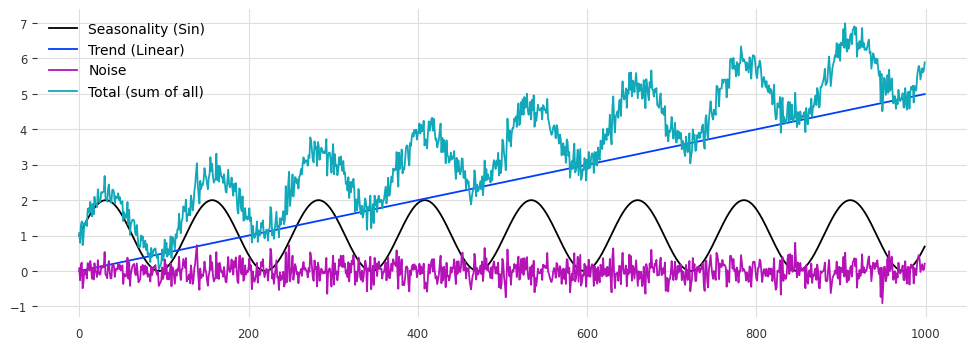

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 4)

data_size = 1000
sin = 1 + np.sin(np.arange(data_size)*.05)
linear = np.arange(data_size)*.005
data = sin + linear

rng = np.random.default_rng(42)
noise = rng.normal(scale=0.25, size=data_size)
noisy_data = data + noise

# Split the data into train and test sets
train_size = int(data_size * 0.8)
test_size = data_size - train_size
train, test = data[:train_size], data[train_size:]
noisy_train, noisy_test = noisy_data[:train_size], noisy_data[train_size:]


plt.plot(sin, label='Seasonality (Sin)')
plt.plot(linear, label='Trend (Linear)')
plt.plot(noise, label='Noise')
# plt.plot(data, label='Sin + Linear')
plt.plot(noisy_data, label='Total (sum of all)')
plt.legend()
plt.show()

In [242]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.statistics import plot_acf, check_seasonality, stationarity_test_adf
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler

from darts.models import *
# from darts.models import (
#     NaiveSeasonal,
#     NaiveDrift,
#     AutoARIMA,
#     ARIMA,
#     ExponentialSmoothing,
#     StatsForecastAutoETS,
#     RNNModel,
#     TCNModel,
#     TransformerModel,
#     NBEATSModel,
#     BlockRNNModel,
#     VARIMA,
#     LightGBMModel,
# )


### Hierarchical time series 
[Textbook example](https://otexts.com/fpp3/hts.html#hierarchical-time-series)

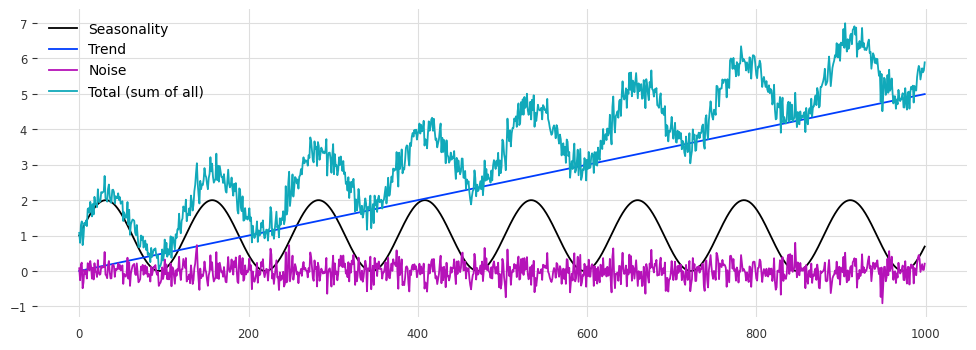

In [146]:
rng = np.random.default_rng(42)
df = pd.DataFrame({
    'seasonality': 1 + np.sin(np.arange(data_size)*.05),
    'trend': np.arange(data_size)*.005,
    'noise': rng.normal(scale=0.25, size=data_size),
})
df['total'] = df['seasonality'] + df['trend'] + df['noise']
plt.plot(df['seasonality'], label='Seasonality')
plt.plot(df['trend'], label='Trend')
plt.plot(df['noise'], label='Noise')
plt.plot(df['total'], label='Total (sum of all)')
plt.legend()
plt.show()

In [147]:
# df2 = pd.DataFrame({
#     'seasonality': 1 + np.cos(np.arange(data_size)*.05),
#     'trend': np.arange(data_size)**.25,
#     'noise': rng.lognormal(mean=0., sigma=.25, size=data_size),
# })
# df2['total'] = df2['seasonality'] + df2['trend'] + df2['noise']
# plt.plot(df2['seasonality'], label='Seasonality')
# plt.plot(df2['trend'], label='Trend')
# plt.plot(df2['noise'], label='Noise')
# plt.plot(df2['total'], label='Total (sum of all)')
# plt.legend()
# plt.show()

In [163]:
series = TimeSeries.from_dataframe(df)

hierarchy = {
    'seasonality': ['total'],
    'trend': ['total'],
    'noise': ['total'],
 }
series = series.with_hierarchy(hierarchy)
train, test = series.split_after(0.75)

## Stationary
A time series is stationary if it does not exhibit any long term trends or obvious seasonality.
- constant variance through time
- constant mean through time


We can use the Augmented Dickey-Fuller (ADF) test to test if the data is stationary. A p-value below 0.05 and a test statistic less than the critical value at the 5% significance level, indicates that the data is stationary at the 5% significance level.

In [278]:
def print_adf_results(adf_test):
    test_statistic, p_value, used_lag, nobs, critical_values, icbest = adf_test
    print(f"Test Statistic: {test_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"Number of Lags Used: {used_lag}")
    # print(f"Number of Observations: {nobs}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"    {key}: {value:.4f}")
    print(f"Maximized Information Criterion: {icbest:.4f}")
    
    

print_adf_results(stationarity_test_adf(train[['total']], maxlag=150))
print('\nWith differencing:')
print_adf_results(stationarity_test_adf(train[['total']].diff(), maxlag=150))
print('\nWith log-transform and differencing:')
print_adf_results(stationarity_test_adf(train[['total']].map(np.log).diff(), maxlag=150))

Test Statistic: -0.3911
P-Value: 0.9116
Number of Lags Used: 108
Critical Values:
    1%: -3.4406
    5%: -2.8661
    10%: -2.5692
Maximized Information Criterion: 171.5560

With differencing:
Test Statistic: -7.6579
P-Value: 0.0000
Number of Lags Used: 107
Critical Values:
    1%: -3.4406
    5%: -2.8661
    10%: -2.5692
Maximized Information Criterion: 169.4533

With log-transform and differencing:
Test Statistic: -1.5004
P-Value: 0.5333
Number of Lags Used: 148
Critical Values:
    1%: -3.4413
    5%: -2.8664
    10%: -2.5693
Maximized Information Criterion: -955.7712


## Inspect Seasonality
[plot_acf](https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html?highlight=plot_acf#darts.utils.statistics.plot_acf)
- m (Optional[int]) – a time lag to highlight on the plot.
- max_lag (int) – maximal lag order to consider.
- alpha (float) – confidence interval to display.

There is seasonality of order 65.
There is seasonality of order 70.
There is seasonality of order 119.
There is seasonality of order 122.
There is seasonality of order 124.


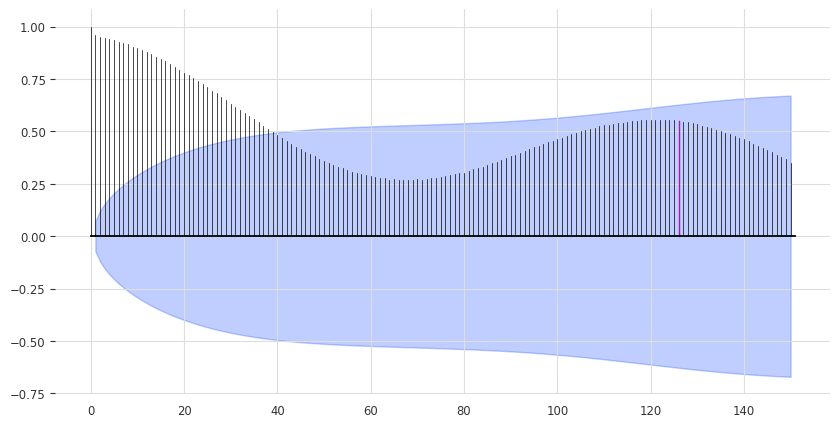

In [201]:
plot_acf(train[['total']], m=126, max_lag=150, alpha=0.05)

for m in range(25, 150):
    is_seasonal, period = check_seasonality(train[['total']], m=m, max_lag=150, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [160]:
# series
scaler_covariates = Scaler()

## Naive Forecast
- NaiveSeasonal(K) "repeats" the value that occured 'K' time steps ago.
- NaiveDrift produces linear predictions, with a slope that is determined by the first and last values of the training set.

<Axes: xlabel='time'>

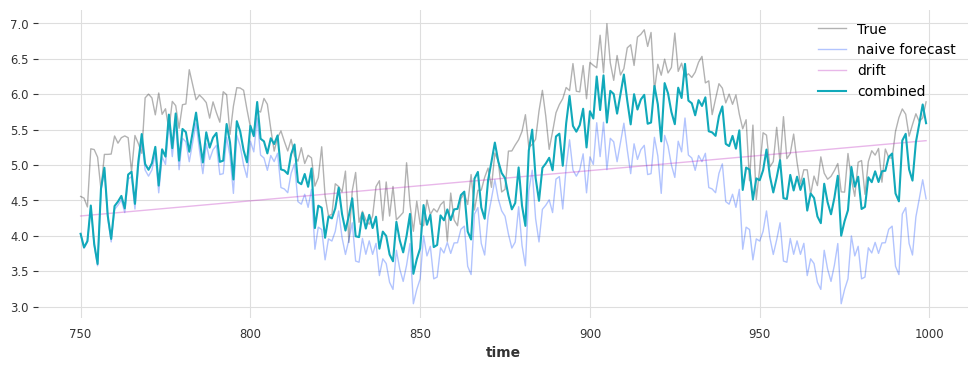

In [220]:
seasonal_model = NaiveSeasonal(K=126)
seasonal_model.fit(train[['total']])
seasonal_forecast = seasonal_model.predict(len(test))

drift_model = NaiveDrift()
drift_model.fit(train[['total']])
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train[['total']].last_value()

# train[['total']].plot(label='True Train', linewidth=1)
test[['total']].plot(label='True', linewidth=1, alpha=0.3)
seasonal_forecast.plot(label="naive forecast", linewidth=1, alpha=0.3)
drift_forecast.plot(label="drift", linewidth=1, alpha=0.3)
combined_forecast.plot(label="combined", linewidth=1.5)

In [226]:
def fit_predict_plot(model, model_name):
    model.fit(train[['total']])
    pred = model.predict(len(test))
    train[['total']].plot(label='Train', linewidth=1)
    test[['total']].plot(label='Test', linewidth=1, alpha=0.6)
    pred.plot(label=f'{model_name}')
    plt.show()
    print(f"{model_name} MAPE: {mape(test[['total']], pred):.2f}%.)")

### Exponential Smoothing

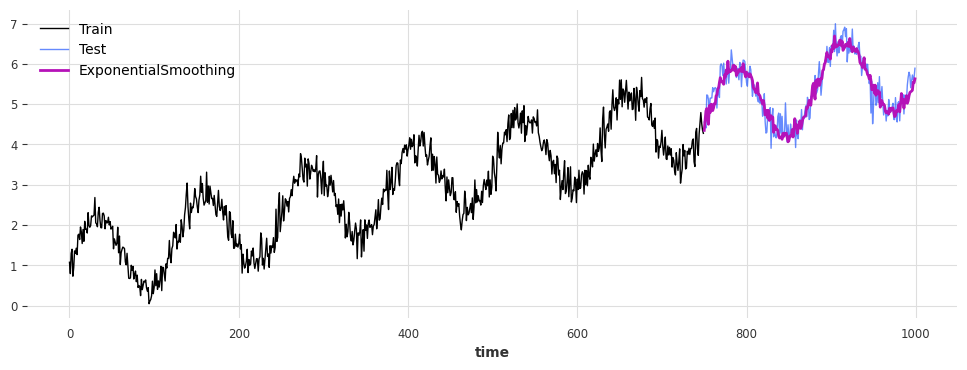

ExponentialSmoothing MAPE: 3.98%.)


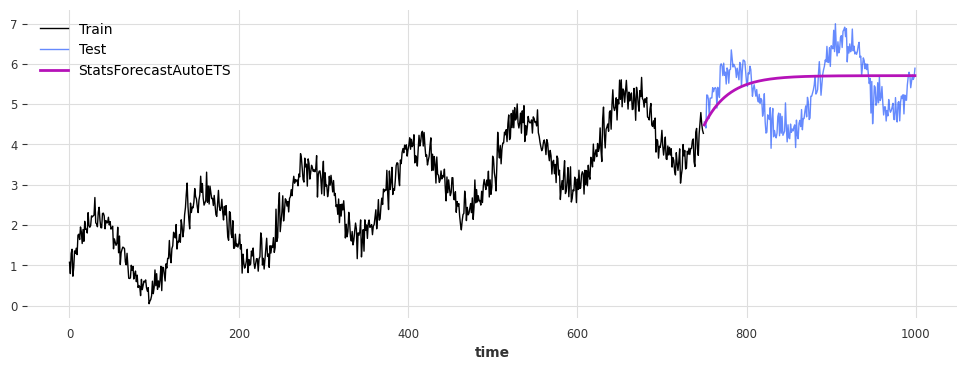

StatsForecastAutoETS MAPE: 12.89%.)


In [231]:
fit_predict_plot(ExponentialSmoothing(seasonal_periods=126), model_name='ExponentialSmoothing')
fit_predict_plot(StatsForecastAutoETS(season_length=126), model_name='StatsForecastAutoETS')

### ARIMA
[ARIMA docs](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.arima.html#darts.models.forecasting.arima.ARIMA)


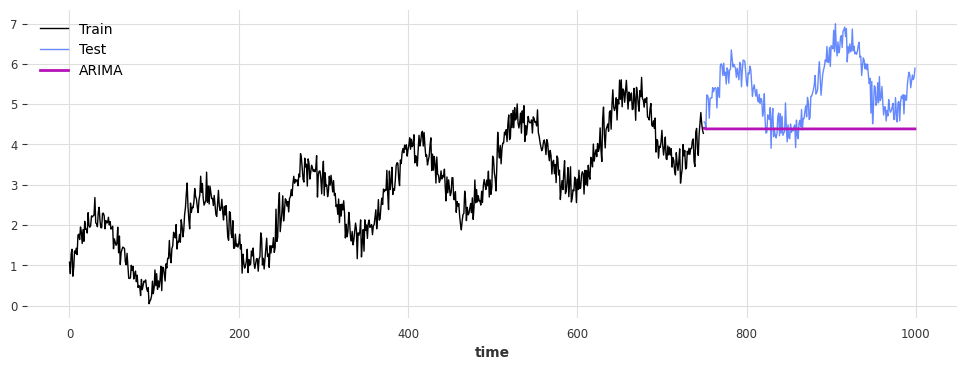

ARIMA MAPE: 17.76%.)


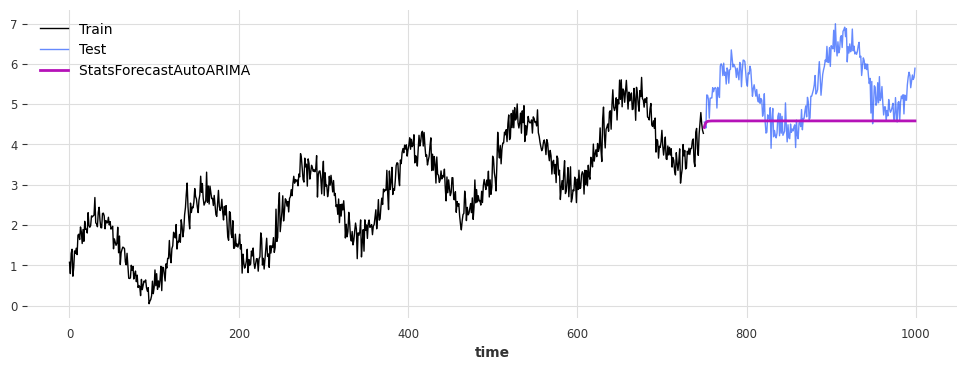

StatsForecastAutoARIMA  MAPE: 15.09%.)


In [238]:
fit_predict_plot(ARIMA(p=2, d=1, q=1), model_name='ARIMA')
# fit_predict_plot(AutoARIMA(), model_name='AutoARIMA')
fit_predict_plot(StatsForecastAutoARIMA(), model_name='StatsForecastAutoARIMA ')

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


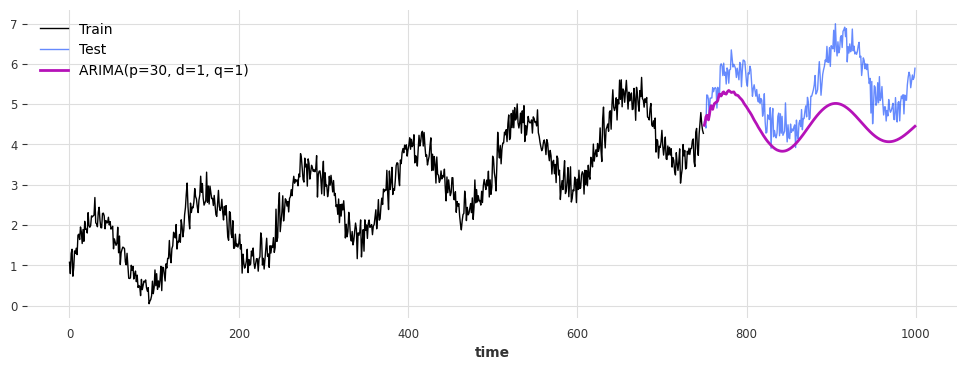

ARIMA(p=30, d=1, q=1) MAPE: 15.22%.)


In [280]:
fit_predict_plot(ARIMA(p=30, d=1, q=1), model_name='ARIMA(p=30, d=1, q=1)')

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


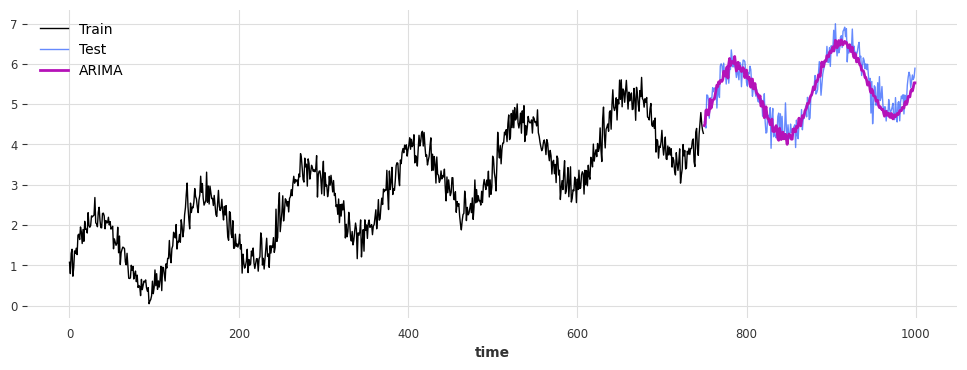

ARIMA MAPE: 4.27%.)


In [241]:
fit_predict_plot(ARIMA(p=126, d=1, q=1), model_name='ARIMA(p=126, d=1, q=1)')

In [4]:
df = pd.read_csv('hier1_with_names.csv')
df.head()

,Total,Hol,VFR,Bus,Oth,NSW - hol,VIC - hol,QLD - hol,SA - hol,WA - hol,...,QLD - oth - city,QLD - oth - noncity,SA - oth - city,SA - oth - noncity,WA - oth - city,WA - oth - noncity,TAS - oth - city,TAS - oth - noncity,NT - oth - city,NT - oth - noncity
0,84503,45906,26042,9815,2740,17589,10412,9078,3089,3449,...,431,271,244,73,168,37,76,24,35,8
1,65312,29347,20676,11823,3466,11027,6025,6310,1935,2454,...,669,170,142,221,170,99,36,61,69,39
2,72753,32492,20582,13565,6114,8910,5060,11733,1569,3398,...,270,1164,397,315,380,1166,32,23,150,338
3,70880,31813,21613,11478,5976,10658,5481,8109,2270,3561,...,214,535,194,260,410,1139,48,43,172,453
4,86893,46793,26947,10027,3126,16152,10958,10047,3023,4287,...,458,557,147,33,162,28,77,60,15,47


In [21]:
TimeSeries.from_dataframe(df)

<TimeSeries (DataArray) (time: 36, component: 89, sample: 1)> Size: 26kB
array([[[8.4503e+04],
        [4.5906e+04],
        [2.6042e+04],
        ...,
        [2.4000e+01],
        [3.5000e+01],
        [8.0000e+00]],

       [[6.5312e+04],
        [2.9347e+04],
        [2.0676e+04],
        ...,
        [6.1000e+01],
        [6.9000e+01],
        [3.9000e+01]],

       [[7.2753e+04],
        [3.2492e+04],
        [2.0582e+04],
        ...,
...
        ...,
        [8.5000e+01],
        [2.9000e+01],
        [5.2000e+01]],

       [[6.5938e+04],
        [3.0938e+04],
        [1.9751e+04],
        ...,
        [6.8000e+01],
        [7.7000e+01],
        [7.2000e+01]],

       [[6.9544e+04],
        [3.1845e+04],
        [2.2758e+04],
        ...,
        [3.7000e+01],
        [2.7000e+01],
        [1.3800e+02]]])
Coordinates:
  * time       (time) int64 288B 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * component  (component) object 712B 'Total' 'Hol' ... 'NT - oth - noncity'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Number of components is larger than 10 (96). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<Axes: xlabel='time'>

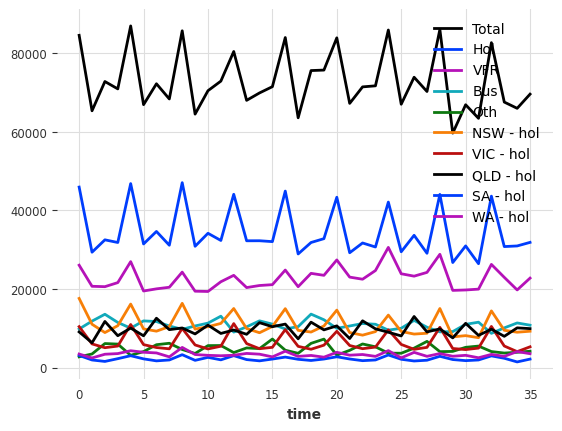

In [22]:
series = AustralianTourismDataset().load()
series.plot()

In [23]:
series

<TimeSeries (DataArray) (time: 36, component: 96, sample: 1)> Size: 28kB
array([[[84503.],
        [45906.],
        [26042.],
        ...,
        [ 6841.],
        [ 3775.],
        [  483.]],

       [[65312.],
        [29347.],
        [20676.],
        ...,
        [ 6119.],
        [ 2091.],
        [ 1431.]],

       [[72753.],
        [32492.],
        [20582.],
        ...,
...
        ...,
        [ 6987.],
        [ 2788.],
        [ 1356.]],

       [[65938.],
        [30938.],
        [19751.],
        ...,
        [ 7669.],
        [ 1433.],
        [ 2685.]],

       [[69544.],
        [31845.],
        [22758.],
        ...,
        [ 7941.],
        [ 1603.],
        [ 1765.]]])
Coordinates:
  * time       (time) int64 288B 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * component  (component) object 768B 'Total' 'Hol' 'VFR' ... 'WA' 'TAS' 'NT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [24]:
from itertools import product

reasons = ["Hol", "VFR", "Bus", "Oth"]
regions = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT"]
city_labels = ["city", "noncity"]
hierarchy = dict()

# Fill in grouping by reason
for reason in reasons:
    hierarchy[reason] = ["Total"]

# Fill in grouping by region
for region in regions:
    hierarchy[region] = ["Total"]

# Fill in grouping by (region, reason)
for region, reason in product(regions, reasons):
    hierarchy["{} - {}".format(region, reason.lower())] = [reason, region]

# Fill in grouping by (region, reason, <city>)
for region, reason, city in product(regions, reasons, city_labels):
    hierarchy["{} - {} - {}".format(region, reason.lower(), city)] = [
        "{} - {}".format(region, reason.lower())
    ]

series_with_hierarchy = series.with_hierarchy(hierarchy)


In [150]:
# hierarchy

In [47]:
len(series_with_hierarchy[:-10])

26

<Axes: xlabel='time'>

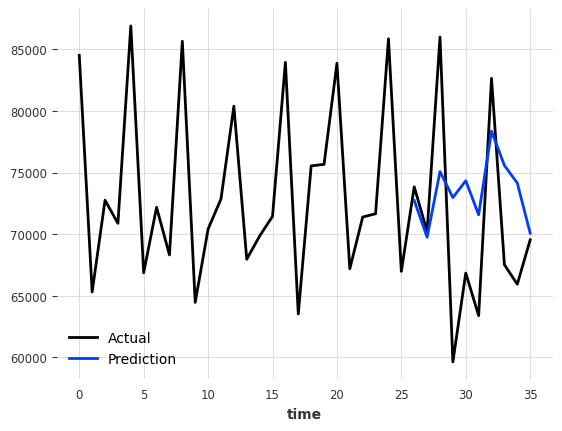

In [51]:
lags = 12
n_val = 12
model = LightGBMModel(lags=lags, output_chunk_length=n_val, verbose=-1)
model.fit(series_with_hierarchy[:-10])
forecast = model.predict(10)
series_with_hierarchy['Total'].plot(label='Actual')
forecast['Total'].plot(label='Prediction')

<Axes: xlabel='time'>

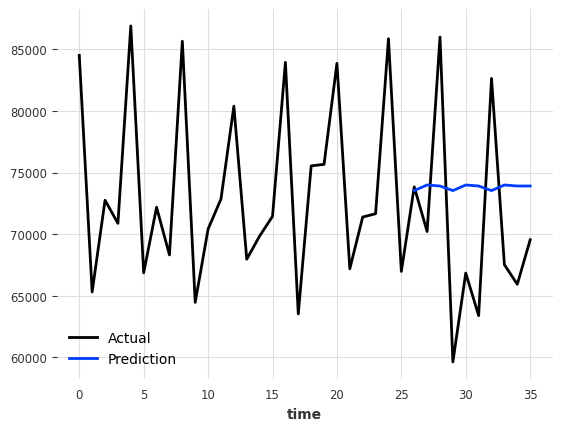

In [53]:
lags = 12
n_val = 3
model = LightGBMModel(lags=lags, output_chunk_length=n_val, verbose=-1)
model.fit(series_with_hierarchy[:-10])
forecast = model.predict(10)
series_with_hierarchy['Total'].plot(label='Actual')
forecast['Total'].plot(label='Prediction')

In [35]:
series_with_hierarchy[:-10]

<TimeSeries (DataArray) (time: 26, component: 1, sample: 1)> Size: 208B
array([[[84503.]],

       [[65312.]],

       [[72753.]],

       [[70880.]],

       [[86893.]],

       [[66866.]],

       [[72182.]],

       [[68318.]],

       [[85651.]],

       [[64467.]],

...

       [[83938.]],

       [[63529.]],

       [[75540.]],

       [[75663.]],

       [[83860.]],

       [[67193.]],

       [[71389.]],

       [[71658.]],

       [[85852.]],

       [[66981.]]])
Coordinates:
  * time       (time) int64 208B 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
  * component  (component) object 8B 'Total'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [8]:
series_with_hierarchy

<TimeSeries (DataArray) (time: 36, component: 96, sample: 1)> Size: 28kB
array([[[84503.],
        [45906.],
        [26042.],
        ...,
        [ 6841.],
        [ 3775.],
        [  483.]],

       [[65312.],
        [29347.],
        [20676.],
        ...,
        [ 6119.],
        [ 2091.],
        [ 1431.]],

       [[72753.],
        [32492.],
        [20582.],
        ...,
...
        ...,
        [ 6987.],
        [ 2788.],
        [ 1356.]],

       [[65938.],
        [30938.],
        [19751.],
        ...,
        [ 7669.],
        [ 1433.],
        [ 2685.]],

       [[69544.],
        [31845.],
        [22758.],
        ...,
        [ 7941.],
        [ 1603.],
        [ 1765.]]])
Coordinates:
  * time       (time) int64 288B 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * component  (component) object 768B 'Total' 'Hol' 'VFR' ... 'WA' 'TAS' 'NT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          {'Hol': ['Total'], 'VFR': ['Total'], 'Bus': ['Total']...

<Axes: xlabel='time'>

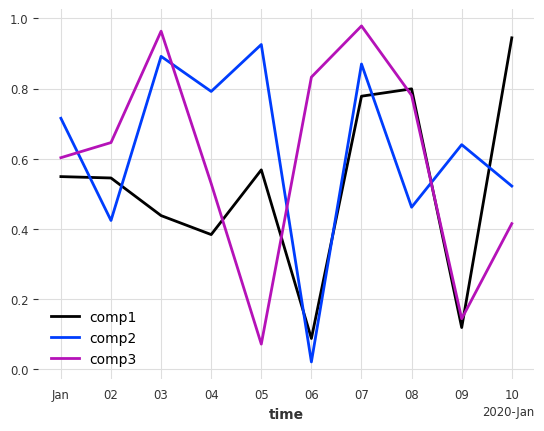

In [11]:
np.random.seed(0)
series = TimeSeries.from_times_and_values(
    times=pd.date_range(start="2020-01-01", periods=10, freq="D"),
    values=np.random.random((10, 3)),
    columns=["comp1", "comp2", "comp3"],
)
series.plot()

In [12]:
series

<TimeSeries (DataArray) (time: 10, component: 3, sample: 1)> Size: 240B
array([[[0.5488135 ],
        [0.71518937],
        [0.60276338]],

       [[0.54488318],
        [0.4236548 ],
        [0.64589411]],

       [[0.43758721],
        [0.891773  ],
        [0.96366276]],

       [[0.38344152],
        [0.79172504],
        [0.52889492]],

       [[0.56804456],
        [0.92559664],
        [0.07103606]],

       [[0.0871293 ],
        [0.0202184 ],
        [0.83261985]],

       [[0.77815675],
        [0.87001215],
        [0.97861834]],

       [[0.79915856],
        [0.46147936],
        [0.78052918]],

       [[0.11827443],
        [0.63992102],
        [0.14335329]],

       [[0.94466892],
        [0.52184832],
        [0.41466194]]])
Coordinates:
  * time       (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * component  (component) <U5 60B 'comp1' 'comp2' 'comp3'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [19]:
np.random.random((10, 3))

array([[0.26455561, 0.77423369, 0.45615033],
       [0.56843395, 0.0187898 , 0.6176355 ],
       [0.61209572, 0.616934  , 0.94374808],
       [0.6818203 , 0.3595079 , 0.43703195],
       [0.6976312 , 0.06022547, 0.66676672],
       [0.67063787, 0.21038256, 0.1289263 ],
       [0.31542835, 0.36371077, 0.57019677],
       [0.43860151, 0.98837384, 0.10204481],
       [0.20887676, 0.16130952, 0.65310833],
       [0.2532916 , 0.46631077, 0.24442559]])

In [15]:
static_covs_multi = pd.DataFrame(data={"cont": [0, 2, 1], "cat": ["a", "c", "b"]})
print(static_covs_multi)

print()

series_multi = series.with_static_covariates(static_covs_multi)
print(series_multi.static_covariates)

   cont cat
0     0   a
1     2   c
2     1   b

static_covariates  cont cat
component                  
comp1               0.0   a
comp2               2.0   c
comp3               1.0   b


In [18]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
series_multi

<TimeSeries (DataArray) (time: 10, component: 3, sample: 1)> Size: 240B
array([[[0.5488135 ],
        [0.71518937],
        [0.60276338]],

       [[0.54488318],
        [0.4236548 ],
        [0.64589411]],

       [[0.43758721],
        [0.891773  ],
        [0.96366276]],

       [[0.38344152],
        [0.79172504],
        [0.52889492]],

       [[0.56804456],
        [0.92559664],
        [0.07103606]],

       [[0.0871293 ],
        [0.0202184 ],
        [0.83261985]],

       [[0.77815675],
        [0.87001215],
        [0.97861834]],

       [[0.79915856],
        [0.46147936],
        [0.78052918]],

       [[0.11827443],
        [0.63992102],
        [0.14335329]],

       [[0.94466892],
        [0.52184832],
        [0.41466194]]])
Coordinates:
  * time       (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * component  (component) <U5 60B 'comp1' 'comp2' 'comp3'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  cont cat\ncomponent               ...
    hierarchy:          None

<TimeSeries (DataArray) (time: 10, component: 3, sample: 1)> Size: 240B
array([[[0.53838236],
        [0.76760291],
        [0.5858723 ]],

       [[0.53379911],
        [0.44559984],
        [0.63339497]],

       [[0.40867839],
        [0.96264143],
        [0.98352151]],

       [[0.34553764],
        [0.85213738],
        [0.50448193]],

       [[0.56080821],
        [1.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.8391347 ]],

       [[0.80582569],
        [0.93860633],
        [1.        ]],

       [[0.83031647],
        [0.48737748],
        [0.78173972]],

       [[0.03631917],
        [0.68446821],
        [0.07968118]],

       [[1.        ],
        [0.55405564],
        [0.37861678]]])
Coordinates:
  * time       (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
  * component  (component) <U5 60B 'comp1' 'comp2' 'comp3'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None